In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bambi as bmb
import arviz as az
from sklearn import preprocessing, tree
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.read_csv('/content/drive/My Drive/ds102_master.csv', low_memory=False)
data['D'] = data['D'] / 1000 # I am changing the units from Megawatts to Gigawatts

In [3]:
data

,Region,UTC time,Local date,Hour,Local time,Time zone,DF,D,Sum (NG),NG: COL,...,NG: OIL,NG: WAT,NG: SUN,NG: WND,NG: OTH,CO2 Emissions Generated,day,month,year,dotw
0,CAL,01Jan2019 9:00:00,2019-01-01,0,01Jan2019 1:00:00,Pacific,"26,940",26876.0,"18,423","1,778",...,89.0,"2,295",-22,"2,604",779,"5,341",1,1,2019,1
1,CAL,01Jan2019 10:00:00,2019-01-01,1,01Jan2019 2:00:00,Pacific,"25,922",25989.0,"17,613","1,765",...,89.0,"2,002",-22,"2,514",731,"5,174",1,1,2019,1
2,CAL,01Jan2019 11:00:00,2019-01-01,2,01Jan2019 3:00:00,Pacific,"25,159",25295.0,"17,235","1,743",...,88.0,"1,724",-25,"2,539",724,"5,115",1,1,2019,1
3,CAL,01Jan2019 12:00:00,2019-01-01,3,01Jan2019 4:00:00,Pacific,"24,700",24884.0,"17,147","1,727",...,90.0,"1,757",-25,"2,464",727,"5,084",1,1,2019,1
4,CAL,01Jan2019 13:00:00,2019-01-01,4,01Jan2019 5:00:00,Pacific,"24,699",24922.0,"17,553","1,747",...,91.0,"1,962",-26,"2,280",751,"5,245",1,1,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669859,TEX,17Nov2024 2:00:00,2024-11-16,19,16Nov2024 20:00:00,Central,"48,471",48916.0,"48,334","5,374",...,NaN,4.0,1,"23,626",0,"12,332",16,11,2024,5
669860,TEX,17Nov2024 3:00:00,2024-11-16,20,16Nov2024 21:00:00,Central,"47,212",48221.0,"47,849","4,919",...,NaN,4.0,0,"24,075",0,"11,658",16,11,2024,5
669861,TEX,17Nov2024 4:00:00,2024-11-16,21,16Nov2024 22:00:00,Central,"45,985",47231.0,"46,950","4,722",...,NaN,4.0,0,"23,925",0,"11,213",16,11,2024,5
669862,TEX,17Nov2024 5:00:00,2024-11-16,22,16Nov2024 23:00:00,Central,"44,739",45799.0,"45,592","4,814",...,NaN,4.0,0,"23,976",0,"10,681",16,11,2024,5


In [5]:
all_regions_by_day = data.groupby(['Local date', 'Hour', 'day', 'month', 'year', 'dotw'], as_index=False).agg({'D': 'sum'})
all_regions_by_day

,Local date,Hour,day,month,year,dotw,D
0,2019-01-01,0,1,1,2019,1,385.191
1,2019-01-01,1,1,1,2019,1,376.938
2,2019-01-01,2,1,1,2019,1,370.029
3,2019-01-01,3,1,1,2019,1,365.565
4,2019-01-01,4,1,1,2019,1,365.580
...,...,...,...,...,...,...,...
51529,2024-11-16,19,16,11,2024,5,441.486
51530,2024-11-16,20,16,11,2024,5,435.284
51531,2024-11-16,21,16,11,2024,5,426.996
51532,2024-11-16,22,16,11,2024,5,416.985


# Frequentist GLM

In [12]:
y = all_regions_by_day['D']  # demand
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # predictors
X = sm.add_constant(X)

In [13]:
gaussian_model = sm.GLM(y, X, family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                51534
Model:                            GLM   Df Residuals:                    51530
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          4754.6
Method:                          IRLS   Log-Likelihood:            -2.9129e+05
Date:                Tue, 03 Dec 2024   Deviance:                   2.4501e+08
Time:                        05:52:00   Pearson chi2:                 2.45e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2434
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        413.0801      0.939    439.946      0.0

In [10]:
y = all_regions_by_day['D']  # demand
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # predictors
X = sm.add_constant(X)
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                51534
Model:                            GLM   Df Residuals:                    51530
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.5876e+05
Date:                Tue, 03 Dec 2024   Deviance:                   5.0723e+05
Time:                        05:49:42   Pearson chi2:                 5.20e+05
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9432
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0266      0.001   9406.560      0.0

In [11]:
y = all_regions_by_day['D']  # demand
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # predictors
X = sm.add_constant(X)
negbinom_model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
negbinom_results = negbinom_model.fit()
print(negbinom_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                51534
Model:                            GLM   Df Residuals:                    51530
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6768e+05
Date:                Tue, 03 Dec 2024   Deviance:                       1072.2
Time:                        05:51:20   Pearson chi2:                 1.10e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006384
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0229      0.014    441.818      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [14]:
y = all_regions_by_day['D']  # demand
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # predictors
X = sm.add_constant(X)
gamma_model = sm.GLM(y, X, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                51534
Model:                            GLM   Df Residuals:                    51530
Model Family:                   Gamma   Df Model:                            3
Link Function:           InversePower   Scale:                        0.021595
Method:                          IRLS   Log-Likelihood:            -2.8934e+05
Date:                Tue, 03 Dec 2024   Deviance:                       1086.5
Time:                        05:55:38   Pearson chi2:                 1.11e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2494
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024   4.42e-06    544.273      0.0

TO DO:
- Compare AIC (using log-likelihood)
- Compare chi^2
- Compare r_squared
- (technically gamma is better, but we have not really learned that in this class)
- main takeaway, much more interpretable, but like not really relevant for some of our features (i.e., dotw and month kinda make no sense since they are more categorical feartures in this case)

# Bayesian GLM

In [18]:
gaussian_b_model = bmb.Model(formula='D ~ Hour + dotw + month', data=all_regions_by_day, family="gaussian")
gaussian_trace = gaussian_b_model.fit(random_seed=0)

Output()

Output()

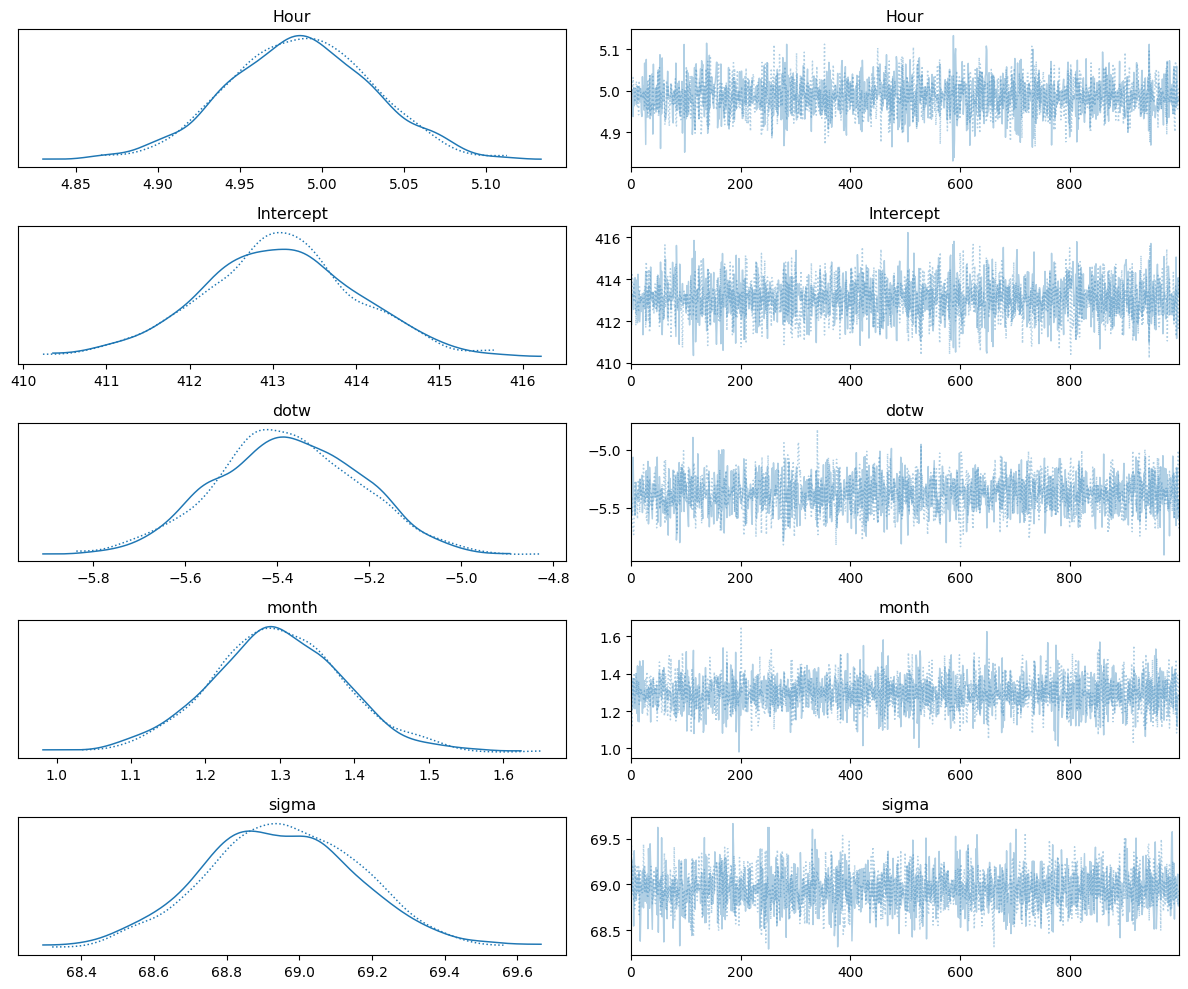

In [20]:
az.plot_trace(gaussian_trace)
plt.tight_layout()

TO DO:
- some analysis and write up
- i guess we could potentially compare it to gamma, however we would need to a do a little bit more research potentially

# Non-Parametric Model

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
# Define the response variable and predictors
y = all_regions_by_day['D']  # Response variable
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # Predictors

# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)

# Training
tree_model.fit(X_train, y_train)

# Outcome
y_pred = tree_model.predict(X_test)

# Tools
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

Root Mean Squared Error: 40.109578519486824
R-squared: 0.7337486596881291


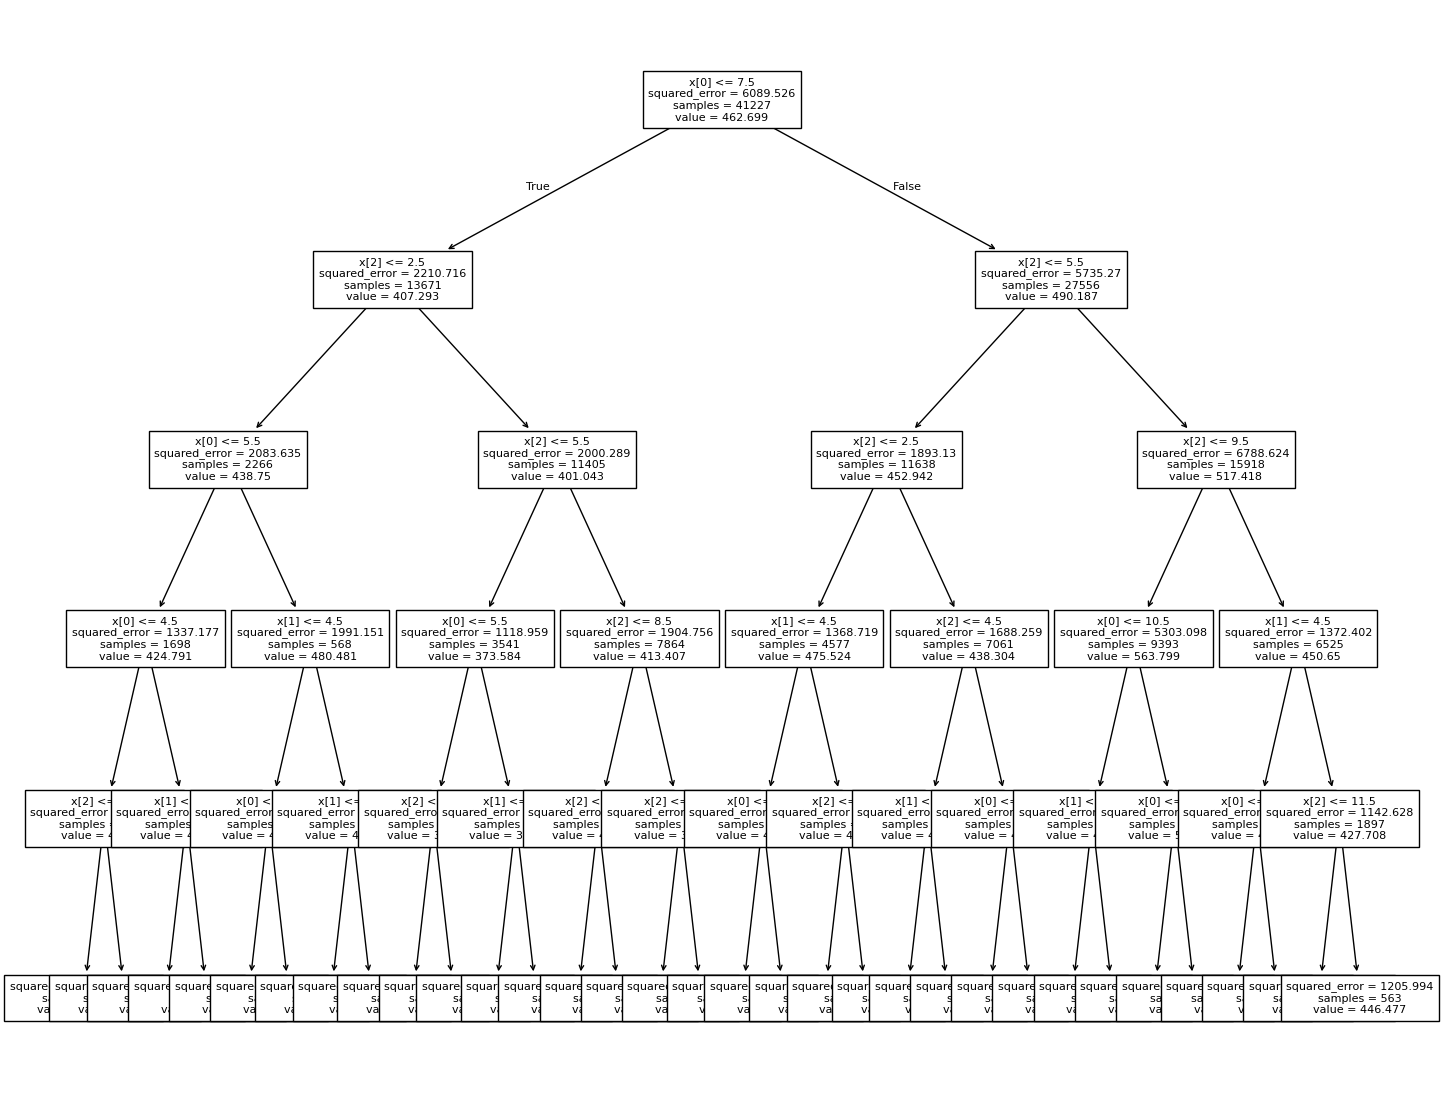

In [40]:
# in terms of putting this in our final report, we need to truncare it to about depth of 3 for visualization purposes
clf = tree_model
fig, ax = plt.subplots(figsize=(17, 14))
tree.plot_tree(clf, fontsize=8);

In [44]:
y = all_regions_by_day['D']
X = all_regions_by_day[['Hour', 'dotw', 'month']]  # predictors

# training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# random forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# training
rf_model.fit(X_train, y_train)

# predict
y_pred = rf_model.predict(X_test)

# tools
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

Root Mean Squared Error: 29.969417210381753
R-squared: 0.851354351051766


- performs much better than decision tree
- however, there is no easy visualization for this one, some interpretability is lost
- explain more about how random forest works

Can ignore for now.